# KNN - Multiclass Classification - Iris Dataset

In this notebook, we use Scikit-Learn to introduce various steps of Machine Learning for performing **multi-class classification** using the K Nearest Neighbors (K-NN) model. The steps include:

- Creating test dataset
- Creating the KNN classifier model
- Model selection via hyperparameter tuning
- Evaluate a KNN model using accuracy, precision, recall, F1 score and confusion matrix


### Dataset

We will use the Iris dataset, which is a multivariate data set. It is a famous dataset that contains the sepal and petal length and width of 150 Iris flowers of three different species: Iris-Setosa, Iris-Versicolor, and Iris-Virginica

There are 4 features: 
- sepal length (cm)
- sepal width (cm)
- petal length (cm)
- petal width (cm)

Total number of samples: 150

The target (label) is coded as follows:
- Setosa: 0
- Versicolor: 1
- Virginica: 2


The dataset is also known as Fisher's Iris data set as it was introduced by the British statistician and biologist Ronald Fisher in his 1936 paper "The use of multiple measurements in taxonomic problems as an example of linear discriminant analysis".


<img src="http://engineering.unl.edu/images/uploads/IrisFlowers.png" width=800, height=400>

In [1]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

## Load Data

First load the data and explore the feature names, target names, etc.

In [2]:
iris = datasets.load_iris()

# See the key values
print(list(iris.keys()))

# The feature names
print(list(iris.feature_names))

# The target names
print(list(iris.target_names))

# The target values (codes)
#print(list(iris.target))

['data', 'target', 'target_names', 'DESCR', 'feature_names', 'filename']
['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
['setosa', 'versicolor', 'virginica']


## Create the Data Matrix and the Target Array

In [3]:
# Data Matrix
X = iris["data"]

# Target Array
y = iris["target"] 

print(X.shape)
print(y.shape)

(150, 4)
(150,)


## Create Train and Test Dataset

We use sklearn's train_test_split function to spilt the dataset into training and test subsets. The data is shuffled by default before splitting.

This function splits arrays or matrices into **random** train and test subsets.

For the **reproducibility of the results**, we need to use the same seed for the random number generator. The seed is set by the "random_state" parameter of the split function. 

However, in repeated experiments if we don't want to use the same train and test subsets, then we drop the "random_state" parameter from the funtion.

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

## Standardize the Data


Before applying K-NN on the data we should standardize it. We use Scikit-Learn's StandardScaler object for this purpose. Following methods of this object are used: fit() & transform(). 
- The fit() method computes the mean and standard deviation
- The transform() method performs standardization by centering and scaling (0 mean and unit variance)

It is important to note that the **fit() method must be applied to the training data only**. In other words, the mean and standard deviation should be computed only based on the training data, not using the full dataset that includes test data. Once the mean and standard deviation are computed from the training data, we use them to transform the training set and the test set (and any subsequent new data) **separately**.

### Why do we apply the fit() method only on the training data?
We compute the mean and standard deviation using only the training data to prevent data leakage. If we use the full dataset, these values will contain information about the test subset. It will influence the learning and prediction. The learned model might overfit as it is based on the full dataset (via mean and standard deviation). We must ensure that learning is solely based on training data.


In [5]:
scaler = StandardScaler()

# Fit on training set only.
scaler.fit(X_train)

# Apply transform to both the training set and the test set.
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Nearest Neighbors Classification Using Scikit-Learn 

The scikit-learn implements two different nearest neighbors classifiers: 
- KNeighborsClassifier implements learning based on the  nearest neighbors of each query point, where k is an **integer** value specified by the user. 
- RadiusNeighborsClassifier implements learning based on the number of neighbors within a fixed radius  of each training point, where k is a **floating-point** value specified by the user. This technique is suitable for scenarios in which data is not uniformly sampled.

In this notebook, we will use the KNeighborsClassifier.

## KNeighborsClassifier Hyperparameters

A K-NN model is defined by a set of parameters: nearest neighbors (K), distance metric (p), etc. These are called **hyperparameters**. We need to select the best model based on the optimal values of these hyperparameters, which we set manually. This process is called hyperparameter tuning.

The model parameters are known as **hyperparameters** because the values of these parameters are used to control the learning process. By contrast, the values of other parameters are **learned**. In the K-NN model there is no learning, thus we only tune the hyperparameters to create the optimal model.

Hyperparameters are are passed as arguments to the constructor of the estimator classes. We search the hyperparameter space for the best cross validation score.

We need to set the following hyperparameters to train a KNeighborsClassifier.


- n_neighbors : int, optional (default = 5) Number of neighbors to use by default for kneighbors queries.


- weights : str or callable, optional (default = ‘uniform’) weight function used in prediction. Possible values:

    -- ‘uniform’ : uniform weights. All points in each neighborhood are weighted equally.
    
    -- ‘distance’ : weight points by the inverse of their distance. in this case, closer neighbors of a query point will have a greater influence than neighbors which are further away.
    
    -- [callable] : a user-defined function which accepts an array of distances, and returns an array of the same shape containing the weights.
    

- algorithm : {‘auto’, ‘ball_tree’, ‘kd_tree’, ‘brute’}, optional. Algorithm used to compute the nearest neighbors:

    -- ‘ball_tree’ will use BallTree
    
    -- ‘kd_tree’ will use KDTree
    
    -- ‘brute’ will use a brute-force search.
    
    -- ‘auto’ will attempt to decide the most appropriate algorithm based on the values passed to fit method.
    
    -- Note: fitting on sparse input will override the setting of this parameter, using brute force.


- leaf_size : int, optional (default = 30). Leaf size passed to BallTree or KDTree. This can affect the speed of the construction and query, as well as the memory required to store the tree. The optimal value depends on the nature of the problem.


- p : integer, optional (default = 2)
    
    -- Power parameter for the Minkowski metric. When p = 1, this is equivalent to using manhattan_distance (l1), and euclidean_distance (l2) for p = 2. For arbitrary p, minkowski_distance (l_p) is used.


- metric : string or callable, default ‘minkowski’. the distance metric to use for the tree. The default metric is minkowski, and with p=2 is equivalent to the standard Euclidean metric. See the documentation of the DistanceMetric class for a list of available metrics.
https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.DistanceMetric.html


- metric_params : dict, optional (default = None). Additional keyword arguments for the metric function.


- n_jobs : int or None, optional (default=None). The number of parallel jobs to run for neighbors search. 

    -- n_jobs= None means 1 unless in a joblib.parallel_backend context. 
   
    -- n_jobs = -1 means using all processors. 


# Model Selection

The process of choosing the optimal hyperparameter values for a model (e.g., K) is known as model selection.

First, we select a model based on just one hyperparameter, i.e., the number of nearest neighbors (K) by using default values for the remaining parameters of the model. This is quick and helps us to get a sense of the optimal model.

Then, we select a model by finding a combination of the optimal hyperparameters. This is rigorous and more useful.


### Model Selection: Choose Optimum K

We determine the optimum K by evaluating the K-NN model for various values of K. We use the default setting for the other model parameters:

- n_neighbors : default = 5

- weights : default = ‘uniform’

- algorithm : default = ‘auto’

- p : default = 2
    
- metric : default = ‘minkowski’

- metric_params : default = None

- n_jobs : default=None

We compute the performance on the training set as well as for the validation set. The validation performance is computed by using the **cross validation** technique. The sklearn.model_selection.cross_val_score function is used for this purpose.

The K-NN model is evaluated by computing a performance measure. There are various performamce measures for classification problems.


#### Performance Measure for Cross Validation

The sklearn KNeighborsClassifier uses, by default, "accuracy" as the performance measure. In a skewed dataset, accuracy doesn't provide a good estimate of the performance of the model. We will have to use confusion matrix, precision, recall, f1 score, etc.

But for now, let's use KNeighborsClassifier's default accuracy score function to evalute the model's performance for various values of K.


In [6]:
# Set the the range of K 
neighbors = np.arange(1,60)

# Two arrays to store training and test accuracies
train_accuracy = np.empty(len(neighbors))
validation_accuracy = np.empty(len(neighbors))

for i,k in enumerate(neighbors):
    
    # Setup a knn classifier with k neighbors
    knn = KNeighborsClassifier(n_neighbors=k)
    
    # Fit the model
    knn.fit(X_train, y_train)
    
    
    # The "score" function returns the mean accuracy on the given train/test data and labels.
    # Note that "accuracy" may not be a good performance measure in a skewed data set
    # Thus, we need to do hyperparameter tuning by using better performance measures (e.g., f1 score, presision, recall)
    
    # Compute training accuracy 
    train_accuracy[i] = knn.score(X_train, y_train)
    
    # Compute validation accuracy using cross-validation
    # Depending on the value set for "cv", the cross_val_score function will return multiple score values
    scores = cross_val_score(knn, X_train, y_train, scoring='accuracy', cv=5)
    
    # Compute the mean of the multiple score values
    validation_accuracy[i] = scores.mean()

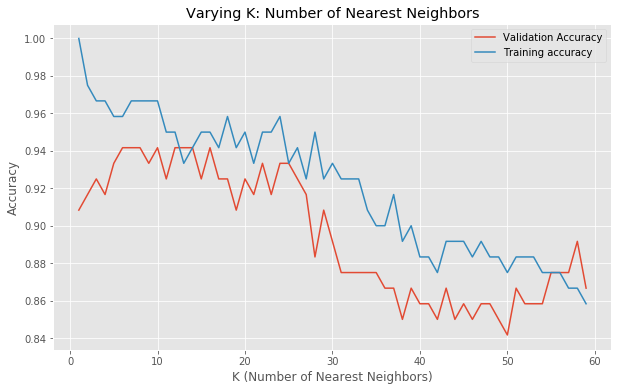

Optimal K:  6


In [7]:
plt.style.use('ggplot')
fig = plt.figure(figsize=(10, 6))
plt.title('Varying K: Number of Nearest Neighbors')
plt.plot(neighbors, validation_accuracy, label='Validation Accuracy')
plt.plot(neighbors, train_accuracy, label='Training accuracy')
plt.legend()
plt.xlabel('K (Number of Nearest Neighbors)')
plt.ylabel('Accuracy')
plt.show()



# Find the value of "K" that gives max validation accuracy
j = 0
max_val_accuracy = validation_accuracy[j]
max_k = 1

for i in neighbors:
    if(validation_accuracy[j] > max_val_accuracy):
        max_val_accuracy = validation_accuracy[j]
        max_k = i
    j +=1
    
print("Optimal K: ", max_k)

## Model Selection: Choose a Combination of Optimal Hyperparameters via Hyperparameter Tuning

The best way to do hyperparameter tuning is to use cross-validation.

We will use Scikit-Learn’s **GridSearchCV** to search the combinations of hyperparameter values that provide the best performance.

We need to tell which hyperparameters we want the GridSearchCV to experiment with, and what values to try out. 

         It will evaluate all the possible combinations of hyperparameter values using cross-validation. 

We will tune the following hyperparameters of the GridSearchCV model.

- n_neighbors 
- weights 
- p 
    


### GridSearchCV Parameters

Following are the most frequenly used parameters by GridSearchCV.

- estimator : estimator object. This is assumed to implement the scikit-learn estimator interface. Either estimator needs to provide a score function, or scoring must be passed.

- param_grid : Dictionary with parameters names (string) as keys and lists of parameter settings to try as values, or a list of such dictionaries, in which case the grids spanned by each dictionary in the list are explored. This enables searching over any sequence of parameter settings.

- scoring : string, callable, list/tuple, dict or None, default: None

    -- A single string (see The scoring parameter: defining model evaluation rules) or a callable (see Defining your scoring strategy from metric functions) to evaluate the predictions on the test set.


- n_jobs : int or None, optional (default=None). Number of jobs to run in parallel. 

    -- n_jobs= None means 1 unless in a joblib.parallel_backend context. 
   
    -- n_jobs = -1 means using all processors. 

- cv : int. Determines the cross-validation splitting strategy. None, to use the default 3-fold cross validation.

- verbose : integer. Controls the verbosity: the higher, the more messages.


### Note: the scoring function

The GridSearchCV takes an argument to define the scoring metric (performance measure). 

See the list of possible scoring functions:
https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter

For multiclass classification, we may use "f1_micro" scoring function. 
- The f1_micro function calculates metrics globally by counting the total true positives, true negatives, false negatives and false positives. More specifically, it computes the precision/recall pair for each class, then sum those to get total precision and recall, which are used to compute the F1 score. The micro average is suitable if there is class imbalance.

- On the other hand, the f1_macro function computes the F1 score for each class, then computes the unweighted mean of all F1 scores. It does not take label imbalance into account.

In the binary classification, F1 score function can be used. We may also use the precision, recall, roc_auc functions.



### Note: Experimenting with the Mahalanobis Distance Metric

We cannot use the Mahalanobis distance metric as a parameter for the grid search.

Because for each iteration of the cross-validation, a new train fold is created which requires to compute the inverse of its covariance matrix.

With the sklearn grid search we cannot compute the inverse of the covariance matrix dynamically for each training fold.

Thus, unfortunately, we can't experiment with the Mahalanobis distance metric using the grid search.


In [8]:
%%time

warnings.filterwarnings('ignore')

# The param_grid tells Scikit-Learn to evaluate all combinations of the hyperparameter values
param_grid = {'n_neighbors': np.arange(1,50), 'p': [1, 2, 10, 50, 100, 500, 1000], 
              'weights': ["uniform", "distance"]}

knn_clf = KNeighborsClassifier()

knn_cv = GridSearchCV(knn_clf, param_grid, scoring='f1_micro', cv=5, verbose=3, n_jobs=-1)
knn_cv.fit(X_train, y_train)


params_optimal_knn = knn_cv.best_params_

print("Best Score: %f" % knn_cv.best_score_)
print("Optimal Hyperparameter Values: ", params_optimal_knn)
print("\n")

Fitting 5 folds for each of 686 candidates, totalling 3430 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    1.3s


Best Score: 0.950000
Optimal Hyperparameter Values:  {'n_neighbors': 7, 'p': 2, 'weights': 'distance'}


CPU times: user 2 s, sys: 134 ms, total: 2.13 s
Wall time: 4.01 s


[Parallel(n_jobs=-1)]: Done 3430 out of 3430 | elapsed:    4.0s finished


## Select The Best Model 

Using the optimal hyperparameter values, create the best model.
Then, fit the model.

## Note on Using Mahalanobis Distance Metric:

The Mahalanobis distance metric works only with the brute force algorithm in sklearn. With this distance metric we tune only the following two hyperparameters.
- weights: "distance", "uniform"
- n_neighbors: int

Also the data should not be standardized before using the Mahalanobis distance metric.

In [9]:
# With the Mahalanobis distance metric only the brute force algorithm works
#knn = KNeighborsClassifier(weights=?, algorithm='brute', n_neighbors=?, metric = "mahalanobis", metric_params= {'V': ?})

# Minkowski distance metric based optimal model selected via hyperparameter tuning.
# The Minkowski distance based model (i.e., knn_cv) is already trained with the optimal hyperparameter values.
# We can use the optimal model (knn_cv) for prediction.
# Or we can use the optimal hyperparameter values to train a new model, as follows.

knn = KNeighborsClassifier(**params_optimal_knn)

knn.fit(X_train, y_train)

y_train_predicted = knn.predict(X_train)

train_accuracy_knn = np.mean(y_train_predicted == y_train)
print("\nTraining Accuracy: ", train_accuracy_knn)


Training Accuracy:  1.0



## Evaluate Model Performance Using Cross-Validation

Evaluate the model's performance using cross-validation. 

Use Scikit-Learn's cross_val_score function. 

Note that the "scoring" argument should be set based on the type of classification (binary/multiclass).


### Benefit of Using Cross-Validation:

Cross-validation allows us to get not only an estimate of the performance of our model, but also a measure of how precise this estimate is (i.e., its standard deviation). 

We would not have this information if we just used one validation set. 

But cross-validation comes at the cost of training the model several times, so it is not always possible.

In [10]:
# Scoring Parameter for Classification:
# https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
# Note: For a skewed data set "accuracy" might not be a good choice for scoring
scores = cross_val_score(knn, X_train, y_train, scoring='f1_micro', cv=5)
print(scores)

print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

[0.91666667 0.91666667 1.         1.         0.91666667]
Accuracy: 0.95 (+/- 0.08)


## Evalute The Model Using Confusion Matrix for Training Data


We use the cross_val_predict() function to performs cross-validation, 

However, unlike cross_val_score, it doesn't return the evaluation scores.

Instead it returns the predictions made on each test fold. 

This means that we get a clean prediction for each instance in the training set.

By “clean” we mean that the prediction is made by a model that never saw the data during training).

In [11]:
y_train_pred = cross_val_predict(knn, X_train, y_train, cv=5)
confusion_matrix(y_train, y_train_pred)

array([[39,  0,  0],
       [ 0, 34,  3],
       [ 0,  3, 41]])

## Evaluate The Model Using Test Data

The KNeighborsClassifier model has a default "score" function that computes the accuracy of the model.

Often times the accuracy is not a good measure.

We also create the confusion matrix for the test data.

In [12]:
# The accuracy of the model
test_accuracy_knn = knn.score(X_test, y_test)
print("\nTest Accuracy: ", test_accuracy_knn)


# No. of Correct Predictions
y_test_predicted = knn.predict(X_test)
print("\nNo. of correct predictions (Test): %d/%d" % (np.sum(y_test_predicted == y_test), len(y_test)))



# Confusion Matrix
print("\nConfusion Matrix (Test Data):\n", confusion_matrix(y_test, y_test_predicted))


Test Accuracy:  1.0

No. of correct predictions (Test): 30/30

Confusion Matrix (Test Data):
 [[11  0  0]
 [ 0 13  0]
 [ 0  0  6]]


## Confusion Matrix for Test Data

Using pandas crosstab, we create a better visualization of the confusion matrix.

In [13]:
pd.crosstab(y_test, y_test_predicted, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted   0   1  2  All
True                     
0          11   0  0   11
1           0  13  0   13
2           0   0  6    6
All        11  13  6   30

## Summary of Classification Metrics

We can build a text report showing the main classification metrics.

In [14]:
print(classification_report(y_test,y_test_predicted))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        11
           1       1.00      1.00      1.00        13
           2       1.00      1.00      1.00         6

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30

